In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
import matplotlib.ticker as tick
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

In [26]:
# first of all, take a look how the data looks like
weeks = 191005 # 1 sample week. MTA uses the data on each Saturday, e.g. 10/05/2019, to name their data file.

# url of data source
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'

df_sample = pd.read_csv(url.format(week)) 
df_sample.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/28/2019,00:00:00,REGULAR,7215740,2444319
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/28/2019,04:00:00,REGULAR,7215766,2444322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/28/2019,08:00:00,REGULAR,7215788,2444357
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/28/2019,12:00:00,REGULAR,7215862,2444436
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/28/2019,16:00:00,REGULAR,7216108,2444474


In [96]:
indx = (df_sample['STATION'] == '59 ST COLUMBUS')
a = df_sample.loc[indx]
a.to_csv('59st')

In [3]:
# input sample weeks (each Saturday)
# weeks = [191012, 191019, 191026, 191102]
weeks = [191005, 191012, 191019] # 1 sample week

# url of data source
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'

# input interested lines (refer to 'Remote-Booth-Station.xls' for exact station names)
lines = ['A']

# get data of interested stations
# note these lines may take a while to run
df_list = []
for week in weeks:
    df_temp = pd.read_csv(url.format(week))    
    ind = (df_temp['UNIT'] == None)
    print('week: ', week) # print out week to know how far we have gone
    for line in lines:
        ind = (ind | df_temp['LINENAME'].str.contains(line))
        print('  line: ', line) # also print out station to know how far we have gone
    df_list.append(df_temp.loc[ind])

week:  191005
  line:  A
week:  191012
  line:  A
week:  191019
  line:  A


In [85]:
mta_df = pd.concat(df_list)
mta_df.sort_values(by = ['STATION'], inplace = True)
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
70148,N137,R354,00-06-01,104 ST,A,IND,10/15/2019,20:00:00,REGULAR,1681115231,978345287
69605,N137,R354,00-00-00,104 ST,A,IND,10/04/2019,08:00:00,REGULAR,301455,191435
69604,N137,R354,00-00-00,104 ST,A,IND,10/04/2019,04:00:00,REGULAR,301164,191418
69603,N137,R354,00-00-00,104 ST,A,IND,10/04/2019,00:00:00,REGULAR,301155,191403
69602,N137,R354,00-00-00,104 ST,A,IND,10/03/2019,20:00:00,REGULAR,301130,191322


In [86]:
# this section calculates No. of Entries and Exits for each turnstile at a same-day level
temp_d = defaultdict(list)
temp_d1 = defaultdict(list)
turnstile_d = {}
turnstile_d1 = {}

# collapse data to a same-day level
for row in mta_df.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    exits = row[11]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(entries)
    temp_d1[k].append(exits)
    
for key, value in temp_d.items():
    entry = abs(max(value) - min(value)) # (max - min) of a day
    turnstile_d[key] = [entry]
for key, value in temp_d1.items():
    exit = abs(max(value) - min(value)) # (max - min) of a day
    turnstile_d1[key] = [exit]

In [87]:
# form a dataframe from dictionary
dict_df = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df.rename(columns = {0:'Entries'}, inplace=True)
dict_df1 = pd.DataFrame.from_dict(turnstile_d1, orient='index')
dict_df1.rename(columns = {0:'Exits'}, inplace=True)

dict_df['Exits'] = dict_df1['Exits']
dict_df

,Entries,Exits
"(N137, R354, 00-06-01, 104 ST, A, 10/15/2019)",289,11
"(N137, R354, 00-00-00, 104 ST, A, 10/04/2019)",689,269
"(N137, R354, 00-00-00, 104 ST, A, 10/03/2019)",685,379
"(N137, R354, 00-00-00, 104 ST, A, 10/02/2019)",720,352
"(N137, R354, 00-00-00, 104 ST, A, 10/01/2019)",603,352
...,...,...
"(N094, R029, 01-03-04, WORLD TRADE CTR, 23ACE, 10/07/2019)",529,214
"(N094, R029, 01-03-04, WORLD TRADE CTR, 23ACE, 10/08/2019)",572,196
"(N094, R029, 01-03-03, WORLD TRADE CTR, 23ACE, 10/09/2019)",430,372
"(N094, R029, 01-03-03, WORLD TRADE CTR, 23ACE, 10/10/2019)",446,493


In [88]:
# convert back to another format
turnstile_df = pd.DataFrame(columns=[])
turnstile_df['CA'] = [row[0][0] for row in dict_df.itertuples()]
turnstile_df['unit'] = [row[0][1] for row in dict_df.itertuples()]
turnstile_df['scp'] = [row[0][2] for row in dict_df.itertuples()]
turnstile_df['station'] = [row[0][3] for row in dict_df.itertuples()]
turnstile_df['linename'] = [row[0][4] for row in dict_df.itertuples()]
turnstile_df['date'] = [row[0][5] for row in dict_df.itertuples()]
turnstile_df['entries'] = [row[1] for row in dict_df.itertuples()]
turnstile_df['exits'] = [row[2] for row in dict_df.itertuples()]
turnstile_df.head()

,CA,unit,scp,station,linename,date,entries,exits
0,N137,R354,00-06-01,104 ST,A,10/15/2019,289,11
1,N137,R354,00-00-00,104 ST,A,10/04/2019,689,269
2,N137,R354,00-00-00,104 ST,A,10/03/2019,685,379
3,N137,R354,00-00-00,104 ST,A,10/02/2019,720,352
4,N137,R354,00-00-00,104 ST,A,10/01/2019,603,352


In [90]:
tstile = pd.pivot_table(turnstile_df, values='entries', index=['date'], columns=['station'], aggfunc=np.sum)
tstile.head()

station,104 ST,111 ST,125 ST,14 ST,145 ST,168 ST,175 ST,181 ST,190 ST,34 ST-PENN STA,...,JAY ST-METROTEC,NOSTRAND AV,OZONE PK LEFFRT,PARK PLACE,ROCKAWAY BLVD,ROCKAWAY PARK B,TIMES SQ-42 ST,UTICA AV,W 4 ST-WASH SQ,WORLD TRADE CTR
date,,,,,,,,,,,,,,,,,,,,,
09/28/2019,0,1,17522,11118,14909,9626,8551,6580,3287,59843,...,14143,10922,0,995,1982,419,49592,9944,28372,450
09/29/2019,0,0,14850,8301,12179,6601,6553,5380,6589,51456,...,11337,8762,0,836,1359,254,41671,8238,23094,741
09/30/2019,1569,2227,22058,17018,18440,16861,11677,8060,4385,109913,...,28556,14756,6199,2547,6333,622,75141,13607,31745,16174
10/01/2019,1613,2438,23991,18127,19394,18269,12611,8784,4643,117997,...,30655,15655,6909,2873,6694,625,80513,14634,35842,17173
10/02/2019,2029,2929,27774,21693,24183,20073,13668,10570,5423,125758,...,39894,17580,8011,3176,8013,882,89338,16558,37851,18381


In [99]:
checker = tstile.sum()/len(weeks)
checker.sort_values(ascending = False)

station
59 ST COLUMBUS    16976861.33
34 ST-PENN STA     1095984.67
BEACH 36 ST         756485.67
42 ST-PORT AUTH     576390.00
FULTON ST           514259.67
TIMES SQ-42 ST      511975.33
JAY ST-METROTEC     280133.67
W 4 ST-WASH SQ      236825.00
125 ST              165228.00
CHAMBERS ST         148173.33
145 ST              137675.33
8 AV                128808.33
14 ST               124779.67
168 ST              112685.33
CANAL ST            111263.33
NOSTRAND AV         103752.33
WORLD TRADE CTR      99004.00
UTICA AV             96168.67
175 ST               80091.67
HIGH ST              66671.33
EUCLID AV            66630.67
HOYT-SCHER           65978.67
181 ST               63885.33
INWOOD-207 ST        55662.67
BROADWAY JCT         54227.33
ROCKAWAY BLVD        43138.00
DYCKMAN ST           40769.00
OZONE PK LEFFRT      40517.33
FRANKLIN AV          37725.33
GRANT AV             31072.67
190 ST               30151.33
HOWARD BCH JFK       26386.33
FAR ROCKAWAY         25114.33
80

In [102]:
tstile.drop(columns=['59 ST COLUMBUS'], inplace = True)

In [103]:
tstile_weekly = tstile.sum()/len(weeks)
tstile_weekly.sort_values(ascending=False, inplace=True)

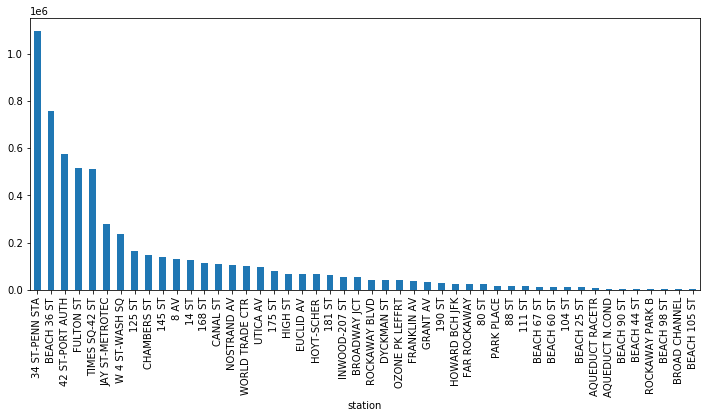

In [106]:
fig, ax = plt.subplots(figsize = (12, 5))
tstile_weekly.plot.bar(ax = ax)
ax.ticklabel_format(axis='y', scilimits=(0,5))

In [107]:
# How about the daily dynamics of these stations?
# stations = turnstile_df['station'].unique()
stations = ['34 ST-PENN STA', '42 ST-PORT AUTH', 'TIMES SQ-42 ST']

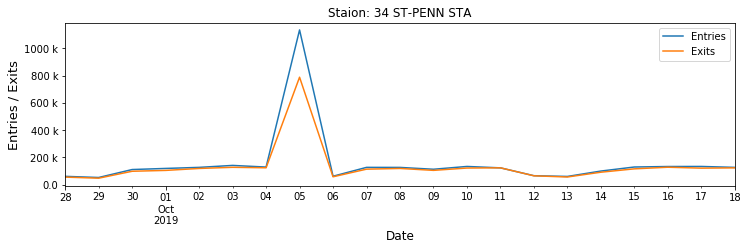

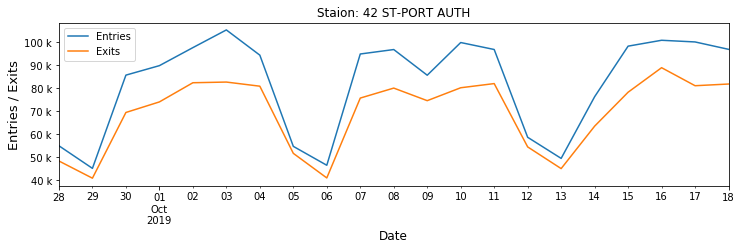

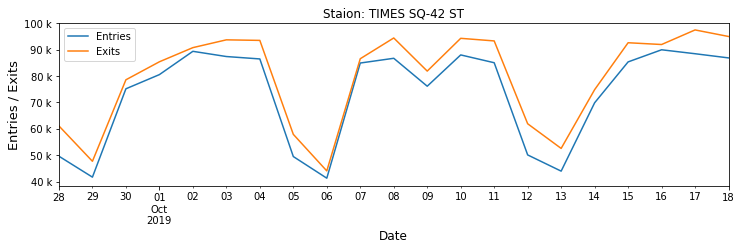

In [121]:
# convert date string to datetime object for plot
turnstile_df['date'] = pd.to_datetime(turnstile_df['date'])
tstile_dynamic = turnstile_df.groupby(['station','date']).sum().sort_values(by=['station', 'date'],ascending=False)
tstile_dynamic.reset_index(inplace=True)
tstile_dynamic.set_index('date', inplace = True)
tstile_dynamic.sort_index(ascending=True, inplace = True)

legend = ['Entries', 'Exits']

def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return '{:.0f} M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{:.0f} k'.format(val)
    else:
        return tick_val

for station in stations:
    f, ax = plt.subplots(figsize = (12,3))
    tstile_dynamic[tstile_dynamic['station'] == station].plot(ax = ax, y = 'entries')
    tstile_dynamic[tstile_dynamic['station'] == station].plot(ax = ax, y = 'exits')
    ax.legend(legend)
    ax.set_xlabel('Date',size = 12)
    ax.set_ylabel('Entries / Exits',size = 13)
    ax.set_title('Staion: ' + station)    
    #ax.ticklabel_format(axis='y', scilimits=(0,6))
    ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

In [175]:
##### calculate weekly average turnstile usage
pd.to_datetime(turnstile_df['date'])
turnstile_df.groupby(['linename', 'station']).sum().sort_values(by='entries',ascending=False).head(10)

turnstile_sum_df = turnstile_df.groupby(['linename','station']).sum()
turnstile_sum_df = turnstile_sum_df.sort_values(by='entries',ascending=False)
turnstile_sum_df.reset_index(inplace=True)

turnstile_sum_df['ave_week'] = turnstile_sum_df['entries']/len(weeks)
turnstile_sum_df['ave_week'] = turnstile_sum_df['ave_week'].astype(int)
turnstile_sum_df.head(10)

,linename,station,entries,exits,ave_week
0,25,FLATBUSH AV-B.C,561974,329696,112394
1,L,CANARSIE-ROCKAW,321617,369911,64323
